In [14]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [15]:
# creating a conenction to the database
conn = sqlite3.connect('reddit-posts.db')
cursor = conn.cursor()

In [16]:

# SQL query to get a list of all tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Execute the query
cursor.execute(query)

# Fetch all the results
tables = cursor.fetchall()

# Print the tables
for table in tables:
    print(table[0])


posts


In [17]:
#converting data into a pandas dataframe
airlines = pd.read_sql_query('SELECT * FROM posts', conn)
print(airlines.shape)
airlines.head()

(250, 9)


,id,title,body,score,author,data,url,sentiment,airline
0,133bh0h,Frontier Baggage Scam,Literally saw something I have never seen in a...,173,kniedrist,1.682815e+09,None,negative,Frontier
1,10bx7c4,Small Claims Court is Great for Air Travel Dis...,"Hi everyone, recently I flew Turkish to Ethiop...",140,[deleted],1.673725e+09,None,negative,Air Travel
2,f0qq9o,Just Had an Older Woman Try to Take My Seat,In India on Airline Indigo. I see a middle-age...,117,ReallyWeirdNormalGuy,1.581163e+09,None,negative,IndiGo
3,12hj4k4,Has anyone experienced this?,TLDR: Norse Atlantic Airways told me my person...,63,Previous_Remove1991,1.681134e+09,https://v.redd.it/x5r5o1yfq3ta1,negative,Atlantic Airways
4,f2amsb,A couple of tips/tools for finding cheap Busin...,Every day I search premium flight deals for ot...,61,Flawingo,1.581438e+09,None,positive,LOT


In [18]:
#totalling the sentiment analysis results
sent_summary = airlines['sentiment'].value_counts()
sent_summary

negative    162
neutral      76
positive     12
Name: sentiment, dtype: int64

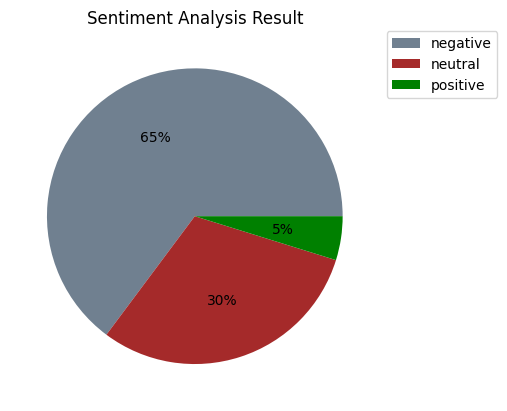

In [19]:
#compiling the results into a pie chart
colors = ['slategray','brown', 'green']
ax = sent_summary.plot(kind='pie', y='score',autopct='%1.0f%%', 
                       colors = colors, ylabel='', labeldistance=None)
ax.set_title('Sentiment Analysis Result')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

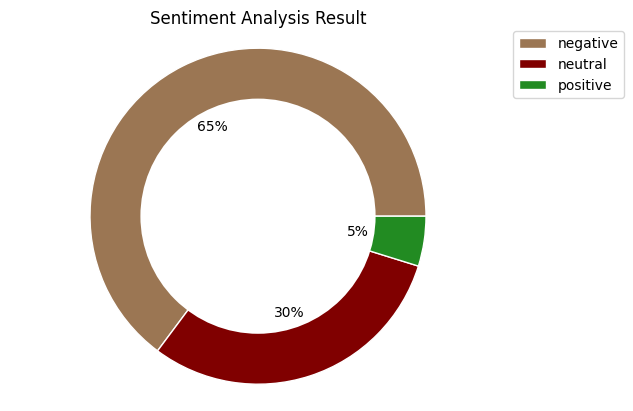

In [20]:
import matplotlib.pyplot as plt

# Compiling the results into a pie chart
colors = ['#9b7653', '#800000', '#228B22']  # Custom colors for the pie slices

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot the pie chart
sent_summary.plot(kind='pie', y='score', autopct='%1.0f%%',
                  colors=colors, ylabel='', labeldistance=None,
                  ax=ax, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Set the title and legend
ax.set_title('Sentiment Analysis Result')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

# Add a white circle at the center to create a donut-like appearance
center_circle = plt.Circle((0, 0), 0.7, fc='white')
ax.add_patch(center_circle)

# Set the aspect ratio to be equal to make the pie chart circular
ax.axis('equal')

# Remove unnecessary spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', length=0)

plt.show()


In [21]:
airlines['airline'].value_counts()

LOT                  21
Frontier             17
easyJet              15
American Airlines    14
Air Canada           13
                     ..
Asiana Airlines       1
EVA Air               1
Lift                  1
Air Greenland         1
Austrian Airlines     1
Name: airline, Length: 71, dtype: int64

## Performing LDA

In [22]:

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,2))

#                        tokenizer = tokenizer.tokenize)

# Changing series to list and replacing NaN with empty strings
air_list = airlines['body'].fillna('').to_list()

# Fit and Transform the documents
train_data = tfidf.fit_transform(air_list) 

In [23]:
# Define the number of topics or components
num_components=6

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [24]:
# Print the topics with their terms
feature_names = tfidf.get_feature_names_out()

for index, component in enumerate(lda_components):
    zipped = zip(feature_names, component)
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:7]
    top_terms_list = [term for term, _ in top_terms_key] 
    print("Topic " + str(index) + ": ", top_terms_list)

Topic 0:  ['flight', 'airlines', 'just', 'plane', 'pay', 'gt', 'hours']
Topic 1:  ['flight', 'hours', 'refund', 'airport', 'said', 'just', 'flights']
Topic 2:  ['flight', 'travel', 'bag', 'seat', 'amp', 'gt', 've']
Topic 3:  ['flight', 'just', 'airline', 'gt', 'flights', 'travel', 'told']
Topic 4:  ['flight', 'told', 'gate', 'flying', 'time', 'going', 'jal']
Topic 5:  ['flight', 'flights', 'refund', 'hours', 'just', 'cancelled', 'credit']


In [25]:
conn.close()